# scRNA-seq Analysis Pipeline

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#scRNA-seq-Analysis-Pipeline" data-toc-modified-id="scRNA-seq-Analysis-Pipeline-1"><span class="toc-item-num"></span>scRNA-seq Analysis Pipeline</a></span></li><li><span><a href="#1.-Load-datasets" data-toc-modified-id="1.-Load-datasets-2"><span class="toc-item-num"></span>1. Load datasets</a></span></li><li><span><a href="#2.-Filter-genes-with-QC" data-toc-modified-id="2.-Filter-genes-with-QC-3"><span class="toc-item-num"></span>2. Filter genes with QC</a></span></li><li><span><a href="#3.-Normalization" data-toc-modified-id="3.-Normalization-4"><span class="toc-item-num"></span>3. Normalization</a></span></li><li><span><a href="#4.-Highest-expressed-genes" data-toc-modified-id="4.-Highest-expressed-genes-5"><span class="toc-item-num"></span>4. Highest expressed genes</a></span></li><li><span><a href="#5.-Plot-samples" data-toc-modified-id="5.-Plot-samples-6"><span class="toc-item-num"></span>5. Plot samples</a></span></li><li><span><a href="#6.-MAGIC" data-toc-modified-id="6.-MAGIC-7"><span class="toc-item-num"></span>6. MAGIC</a></span></li><li><span><a href="#7.-Clustering" data-toc-modified-id="7.-Clustering-8"><span class="toc-item-num"></span>7. Clustering</a></span></li><li><span><a href="#8.-Trajectory-inference" data-toc-modified-id="8.-Trajectory-inference-9"><span class="toc-item-num"></span>8. Trajectory inference</a></span></li><li><span><a href="#9.-Enrichment-analysis" data-toc-modified-id="9.-Enrichment-analysis-10"><span class="toc-item-num"></span>9. Enrichment analysis</a></span></li><li><span><a href="#10.-Gene-Ontology-Enrichment-Analysis" data-toc-modified-id="10.-Gene-Ontology-Enrichment-Analysis-11"><span class="toc-item-num"></span>10. Gene Ontology Enrichment Analysis</a></span></li><li><span><a href="#11.-SingleR-cell-type-prediction" data-toc-modified-id="11.-SingleR-cell-type-prediction-12"><span class="toc-item-num"></span>11. SingleR cell type prediction</a></span></li><li><span><a href="#12.-Library-size-analysis" data-toc-modified-id="12.-Library-size-analysis-13"><span class="toc-item-num"></span>12. Library size analysis</a></span></li><li><span><a href="#References" data-toc-modified-id="References-14"><span class="toc-item-num"></span>References</a></span></li></ul></div>

In [61]:
#%%jupyter_template init
from jupyter_template import magic
magic.init(lambda _=globals: _())

In [62]:
%%jupyter_template code_exec
meta_data_filename = "{{ FileField(name='meta_data_filename', label='Meta data file (.csv or .tsv)', default='GSE116500-metadata.txt.txt', description='Upload metadata as two-column csv format. One column contains sample ids and the other column contains sample labels').value }}"
rnaseq_data_filename = "{{ FileField(name='rnaseq_data_filename', label='RNA-seq data file (.csv or .tsv)', default='GSE116500-expression.txt.txt', description='Upload rna-seq dataset as csv format. The index of the dataset are genes, the columns are samples.').value }}"

meta_class_column_name = "{{ StringField(name='meta_class_column_name', label='Class column name in metadata', default='donor gender', description='class column name of metadata').value }}"
meta_id_column_name = "{{ StringField(name='meta_id_column_name', label='Sample ID column name in metadata', default='Sample_geo_accession', description='sample ID column name of metadata').value }}"

qc_filter_genes = {{ BoolField(name='qc_filter_genes', label='Filter genes by quality control?', default='true', description='Check if you want cells to be filtered by quality control').value }}
qc_threshold = {{ FloatField(name='qc_threshold', label='Mitochondria Quality Control threshold', default='0.05', description='Remove cells that have too many mitochondrial genes expressed.').value }}
log_normalization = {{ BoolField(name='log_normalization', label='Log normalization?', default='true', description='Check if User wants the dataset to be log-transformed').value }}
normalization_method = "{{ ChoiceField(name='normalization_method',label='Normalization',choices={'Satija et al. (2015, Nature Biotechnology)': 'Seurat', 'Zheng et al. (2017, Nature Communications)': 'Zheng17','Weinreb et al. (2018, PNAS)': 'Weignreb17'},default='Satija et al. (2015, Nature Biotechnology)', description='Standard normlization recipe for scRNA-seq datasets').value }}"
highest_expr_n_genes = {{ IntField(name='highest_expr_n_genes', label='Genes for highest expression', default=20, description='The number of genes with highest expression values').value }}
dim_reduction_method = "{{ ChoiceField(name='dim_reduction_method',label='Method for dimension reduction',choices={'PCA': 'PCA','t-SNE': 't-SNE', 'UMAP': 'UMAP'},default='PCA', description='Dimension reduction methods').value }}"
nr_genes = {{ IntField(name='nr_genes', label='Genes for dimension reduction', default=500, description='The maximum number of genes for dimension reduction analysis').value }}
clustering_algorithm = "{{ ChoiceField(name='clustering_algorithm',label='Method for clustering',choices={'Leiden (Traag et al. (2018, arxiv))': 'Leiden', 'Dendrogram': 'Dendrogram'},default='Leiden (Traag et al. (2018, arxiv))', description='Clustering algorithm').value }}"
trajectory_method = "{{ ChoiceField(name='trajectory_method',label='Trajectory inference method',choices={'DPT(diffusion pseudotime)': 'dpt', 'monocle': 'monocle'},default='DPT(diffusion pseudotime)', description='Trajectory inference algorithm').value }}"
enrichment_groupby = "{{ ChoiceField(name='enrichment_groupby',label='Group for enrichment analysis',choices={'cluster': 'cluster', 'cell type': 'cell_type'},default='cluster', description='Clustering algorithm').value }}"
nr_genesets = {{ IntField(name='nr_genesets', label='Top ranked gene sets', default=15, description='the number of result gene sets').value }}

singleR_analysis = {{ BoolField(name='singleR_analysis', label='singleR analysis?', default='false', description='Check if you want singleR analysis').value }}
species = "{{ ChoiceField(name='species',label='Species',choices={'Human': 'Human','Mouse': 'Mouse'},default='Human', description='Human or Mouse').value }}"

interactive_plot = {{ BoolField(name='interactive_plot', label='Interactive plots?', default='true', description='Check if User wants interactive plots').value }}

```python
meta_data_filename = "GSE116500-metadata.txt.txt"
rnaseq_data_filename = "GSE116500-expression.txt.txt"
meta_class_column_name = "donor gender"
meta_id_column_name = "Sample_geo_accession"
qc_filter_genes = True
qc_threshold = 0.05
log_normalization = True
normalization_method = "Seurat"
highest_expr_n_genes = 20
dim_reduction_method = "PCA"
nr_genes = 500
clustering_algorithm = "Leiden"
trajectory_method = "dpt"
enrichment_groupby = "cluster"
nr_genesets = 15
singleR_analysis = False
species = "Human"
interactive_plot = True
```

In [63]:
import pandas as pd
import os
import urllib3
import requests, json
import sys
import math
import seaborn as sns
import scipy.stats as ss

import plotly
from plotly import tools
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt; plt.rcdefaults()
from matplotlib import rcParams
from matplotlib.lines import Line2D
from matplotlib_venn import venn2, venn3

import IPython
from IPython.display import HTML, display, Markdown, IFrame
from itertools import combinations

from scipy import stats

from sklearn.decomposition import PCA
from sklearn.preprocessing import quantile_transform
from sklearn import cluster
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import umap

from collections import OrderedDict
import random
from time import sleep
import time
import operator
import numpy as np

import warnings

from rpy2 import robjects
from rpy2.robjects import r, pandas2ri
from magic import MAGIC
import chart_studio
import chart_studio.plotly as py

import scanpy as sc
import anndata

warnings.filterwarnings('ignore')
random.seed(0)
chart_studio.tools.set_credentials_file(username='mjjeon', api_key='v0rpMa6lhST28Sq7XqtM')
pandas2ri.activate()
if interactive_plot == True:
    plot_type='interactive'
else:
    plot_type='static'
results = {}

In [64]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)

# 1. Load datasets

In [65]:
if rnaseq_data_filename.endswith(".h5"):
    adata = anndata.read_hdf(rnaseq_data_filename, 'matrix')
else:
    if rnaseq_data_filename.endswith(".csv"):
        expr_df = pd.read_csv(rnaseq_data_filename, index_col=0).sort_index()
    else:
        expr_df = pd.read_csv(rnaseq_data_filename, index_col=0, sep="\t").sort_index()
    if meta_data_filename.endswith(".csv"):
        meta_df = pd.read_csv(meta_data_filename, index_col=0)
    else:
        meta_df = pd.read_csv(meta_data_filename, index_col=0, sep="\t")

    # Match samples between the metadata and the datasets
    meta_df = meta_df.loc[expr_df.columns, :]
    expr_df = expr_df.loc[:,meta_df.index]

    # convert df into anndata
    adata = anndata.AnnData(expr_df.T, obs = pd.DataFrame(meta_df[meta_class_column_name]))
    adata.X = adata.X.astype('float64')

    assert(meta_df.shape[0]==expr_df.shape[1])

In [66]:
# Load dataset from EBI Single Cell Expression Atlas (https://www.ebi.ac.uk/gxa/sc/experiments/E-GEOD-98556/results/tsne)
adata = sc.datasets.ebi_expression_atlas("E-GEOD-98556")
meta_class_column_name='Sample Characteristic[cell type]'
log_normalization = True
dim_reduction_method = 'PCA'
# map gene id to symbol
gene_id_map = pd.read_csv("./data/ensemble_ENSG_to_Genesymbol.txt",sep="\t")
gene_id_map_dict = dict(zip(gene_id_map["Gene stable ID"], gene_id_map["Gene name"]))
adata.var.index = [gene_id_map_dict[x] if x in gene_id_map_dict else x for x in adata.var.index]
adata.var_names_make_unique()

Display datasets

In [67]:
display(adata.to_df().head())

TSPAN6   DPM1     SCYL3     C1orf112  CFH  FUCA2       GCLC  \
SRR5508807    100.844360    0.0  0.000000     1.000000  2.0   31.0   0.000000   
SRR5508808    671.858704    0.0  0.000000     0.000000  0.0    0.0   0.000000   
SRR5508809      4.154311  972.0  0.000000  4480.025879  0.0    0.0  22.047575   
SRR5508810      5.929660    0.0  0.000000     1.000000  0.0  102.0  15.508366   
SRR5508811  14480.000000    0.0  1.006937     1.000000  0.0    0.0   0.000000   

            NFYA      STPG1     NIPAL3  ...  AC008012.1  AC087721.2  \
SRR5508807   0.0   0.000000   9.000000  ...    1.001544       419.0   
SRR5508808   0.0   1.000000  36.009151  ...    4.026649         0.0   
SRR5508809   1.0   0.000000   1.000000  ...    0.000000         0.0   
SRR5508810   3.0  32.381165  12.820030  ...    0.000000         0.0   
SRR5508811   0.0   5.087357   0.000000  ...    0.000000         0.0   

            AL133353.2  AC018362.3  AC112128.1  AC000120.4  AL135905.2  \
SRR5508807         0.0    0.000000         0.0         0.0         1.0   
SRR5508808         0.0    0.000000         0.0         0.0      1531.0   
SRR5508809         0.0   41.889374         0.0         0.0         0.0   
SRR5508810         0.0   25.618359         0.0         0.0         0.0   
SRR5508811         0.0    0.000000         0.0         0.0         0.0   

            AC012213.5  AL589743.7  AL355312.6  
SRR5508807         0.0         0.0  282.394287  
SRR5508808         0.0         0.0    0.000000  
SRR5508809         0.0         0.0  293.050659  
SRR5508810         0.0         0.0    0.000000  
SRR5508811         0.0         0.0    0.000000  

[5 rows x 24402 columns]

In [68]:
display(adata.obs)

Sample Characteristic[organism]  \
SRR5508807                    Homo sapiens   
SRR5508808                    Homo sapiens   
SRR5508809                    Homo sapiens   
SRR5508810                    Homo sapiens   
SRR5508811                    Homo sapiens   
...                                    ...   
SRR5509102                    Homo sapiens   
SRR5509103                    Homo sapiens   
SRR5509104                    Homo sapiens   
SRR5509105                    Homo sapiens   
SRR5509106                    Homo sapiens   

            Sample Characteristic Ontology Term[organism]  \
SRR5508807  http://purl.obolibrary.org/obo/NCBITaxon_9606   
SRR5508808  http://purl.obolibrary.org/obo/NCBITaxon_9606   
SRR5508809  http://purl.obolibrary.org/obo/NCBITaxon_9606   
SRR5508810  http://purl.obolibrary.org/obo/NCBITaxon_9606   
SRR5508811  http://purl.obolibrary.org/obo/NCBITaxon_9606   
...                                                   ...   
SRR5509102  http://purl.obolibrary.org/obo/NCBITaxon_9606   
SRR5509103  http://purl.obolibrary.org/obo/NCBITaxon_9606   
SRR5509104  http://purl.obolibrary.org/obo/NCBITaxon_9606   
SRR5509105  http://purl.obolibrary.org/obo/NCBITaxon_9606   
SRR5509106  http://purl.obolibrary.org/obo/NCBITaxon_9606   

           Sample Characteristic[individual]  \
SRR5508807                                H9   
SRR5508808                                H9   
SRR5508809                                H9   
SRR5508810                                H9   
SRR5508811                                H9   
...                                      ...   
SRR5509102                                H9   
SRR5509103                                H9   
SRR5509104                                H9   
SRR5509105                                H9   
SRR5509106                                H9   

            Sample Characteristic Ontology Term[individual]  \
SRR5508807                                              NaN   
SRR5508808                                              NaN   
SRR5508809                                              NaN   
SRR5508810                                              NaN   
SRR5508811                                              NaN   
...                                                     ...   
SRR5509102                                              NaN   
SRR5509103                                              NaN   
SRR5509104                                              NaN   
SRR5509105                                              NaN   
SRR5509106                                              NaN   

           Sample Characteristic[developmental stage]  \
SRR5508807                                     embryo   
SRR5508808                                     embryo   
SRR5508809                                     embryo   
SRR5508810                                     embryo   
SRR5508811                                     embryo   
...                                               ...   
SRR5509102                                     embryo   
SRR5509103                                     embryo   
SRR5509104                                     embryo   
SRR5509105                                     embryo   
SRR5509106                                     embryo   

           Sample Characteristic Ontology Term[developmental stage]  \
SRR5508807      http://purl.obolibrary.org/obo/UBERON_0000922         
SRR5508808      http://purl.obolibrary.org/obo/UBERON_0000922         
SRR5508809      http://purl.obolibrary.org/obo/UBERON_0000922         
SRR5508810      http://purl.obolibrary.org/obo/UBERON_0000922         
SRR5508811      http://purl.obolibrary.org/obo/UBERON_0000922         
...                                                       ...         
SRR5509102      http://purl.obolibrary.org/obo/UBERON_0000922         
SRR5509103      http://purl.obolibrary.org/obo/UBERON_0000922         
SRR5509104      http://purl.obolibrary.org/obo/UBERON_0000922      

In [69]:
display(adata.obs.reset_index().groupby(meta_class_column_name).count())

index  Sample Characteristic[organism]  \
Sample Characteristic[cell type]                                           
embryonic stem cell                 404                              404   
retinal cell                        142                              142   

                                  Sample Characteristic Ontology Term[organism]  \
Sample Characteristic[cell type]                                                  
embryonic stem cell                                                         404   
retinal cell                                                                142   

                                  Sample Characteristic[individual]  \
Sample Characteristic[cell type]                                      
embryonic stem cell                                             404   
retinal cell                                                    142   

                                  Sample Characteristic Ontology Term[individual]  \
Sample Characteristic[cell type]                                                    
embryonic stem cell                                                             0   
retinal cell                                                                    0   

                                  Sample Characteristic[developmental stage]  \
Sample Characteristic[cell type]                                               
embryonic stem cell                                                      404   
retinal cell                                                             142   

                                  Sample Characteristic Ontology Term[developmental stage]  \
Sample Characteristic[cell type]                                                             
embryonic stem cell                                                             404          
retinal cell                                                                    142          

                                  Sample Characteristic[age]  \
Sample Characteristic[cell type]                               
embryonic stem cell                                      404   
retinal cell                                             142   

                                  Sample Characteristic Ontology Term[age]  \
Sample Characteristic[cell type]                                             
embryonic stem cell                                                      0   
retinal cell                                                             0   

                                  Sample Characteristic[sex]  ...  \
Sample Characteristic[cell type]                              ...   
embryonic stem cell                                      404  ...   
retinal cell                                             142  ...   

                                  Sample Characteristic[disease]  \
Sample Characteristic[cell type]                                   
embryonic stem cell                                          404   
retinal cell                                                 142   

                                  Sample Characteristic Ontology Term[disease]  \
Sample Characteristic[cell type]                                                 
embryonic stem cell                                                        404   
retinal cell                                                               142   

                                  Factor Value[single cell identifier]  \
Sample Characteristic[cell type]                                         
embryonic stem cell                                                404   
retinal cell                                                       142   

                                  Factor Value Ontology Term[single cell identifier]  \
Sample Characteristic[cell type]                                                       
embryonic stem cell                                                               0    
retinal cell                                                  

# 2. Filter genes with QC

High expression levels of mitochondrial genes could be an indicator of poor quality cells[1,2]. In a situation where cell membrane is broken, cytoplasmic RNA will be lost, but RNAs enclosed in the mitochondria will be retained.

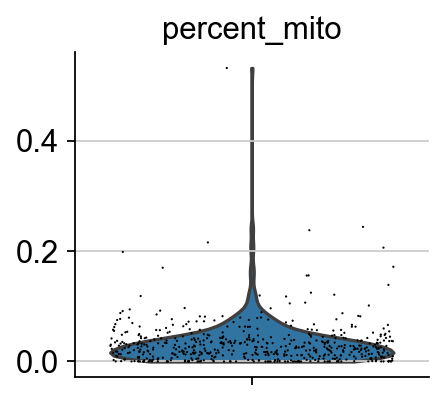

In [70]:
if qc_filter_genes == True:
    if adata.var_names[0].startswith("ENSG") == False:
        mito_genes = adata.var_names.str.startswith('MT-')    
    else:
        gene_symbol_var_names = adata.var_names
        mito_genes = [True if x in gene_id_map_dict and str(gene_id_map_dict[x]).startswith('MT-') else False for x in gene_symbol_var_names ]
    
    # for each cell compute fraction of counts in mito genes vs. all genes
    adata.obs['percent_mito'] = np.sum(
        adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
    
    sc.pl.violin(adata, ['percent_mito'],
             jitter=0.4, multi_panel=True)
    
    adata = adata[adata.obs.percent_mito < qc_threshold, :]
adata.raw = adata

# 3. Normalization

Various normalization method recipes[3,4,5] will be applied to convert raw read counts into informative measures of gene expression and remove factors that affect the analysis.

filtered out 569 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)


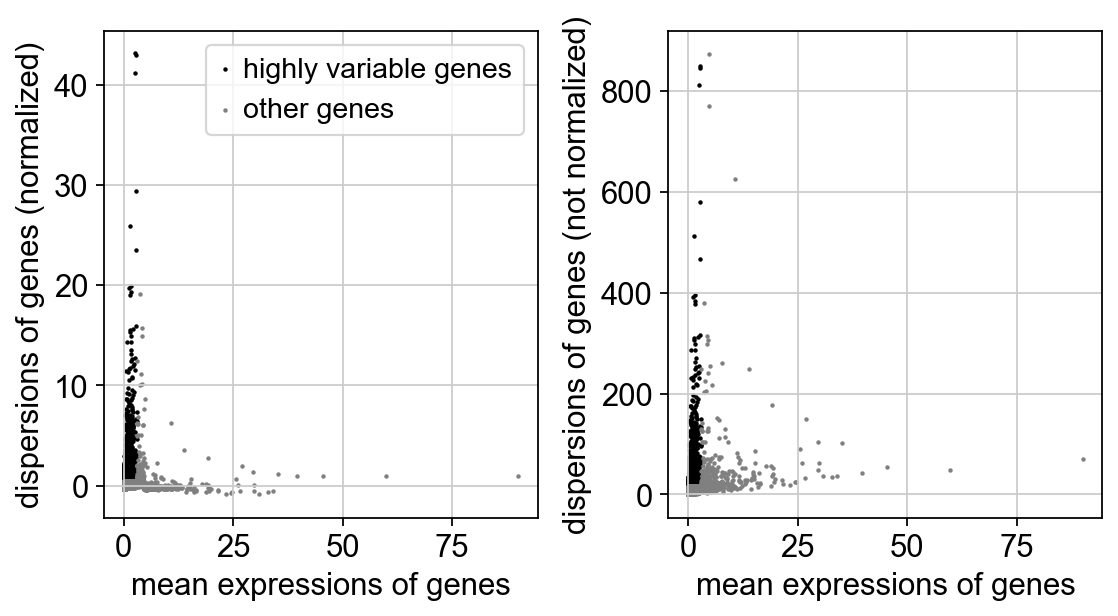

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [71]:
if normalization_method == "Zheng17":
    sc.pp.recipe_zheng17(adata, log=log_normalization, plot=True)
elif normalization_method == "Weinreb17":
    sc.pp.recipe_weinreb17(adata, log=log_normalization, plot=True)
elif normalization_method == "Seurat":
    sc.pp.recipe_seurat(adata, log=log_normalization, plot=True)

# 4. Highest expressed genes

Show those genes that yield the highest fraction of counts in each single cells, across all cells.

normalizing counts per cell
    finished (0:00:00)


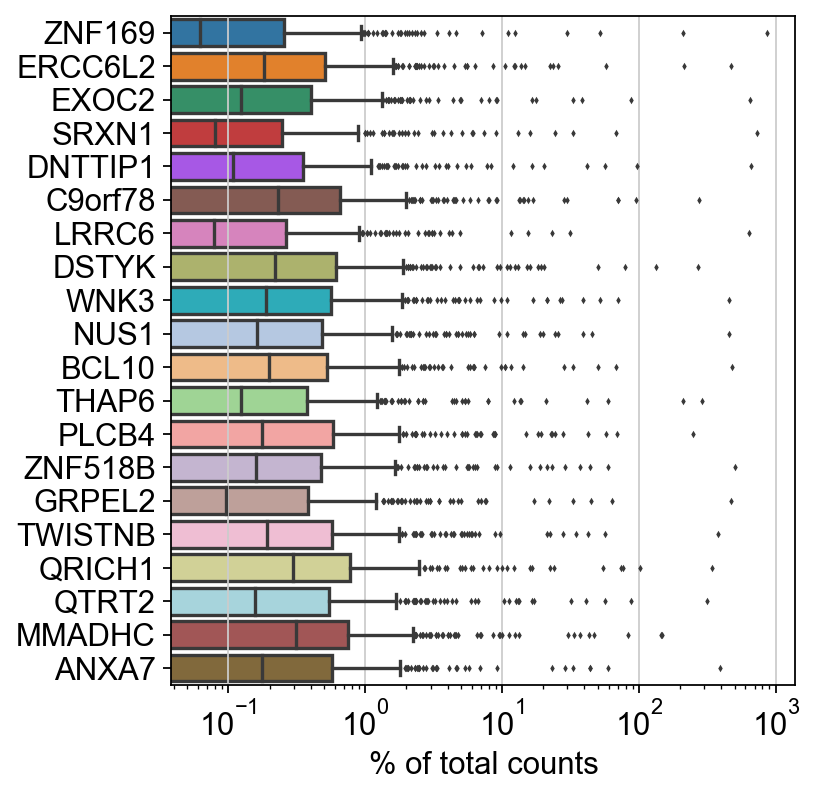

In [72]:
sc.pl.highest_expr_genes(adata, log=log_normalization, n_top=highest_expr_n_genes, )

# 5. Plot samples

Principal Component Analysis (PCA)[6], T-distributed Stochastic Neighbor Embedding (t-SNE)[7], Uniform Manifold Approximation and Projection (UMAP)[8] are statistical techniques used to identify global patterns in high-dimensional datasets. These techniques are commonly used to explore the similarity of biological samples in RNA-seq datasets. To achieve this, gene expression values are transformed into 3-dimensional latent vectors and subsequently visualized using a scatter plot.

In [73]:
def autoselect_color_by(sample_metadata):
    '''Automatically select a column in the sample_metadata df for coloring.
    '''
    color_by = None
    color_type = 'categorical'
    meta_col_nuniques = sample_metadata.nunique()
    # pick a column with the cardinality between 2 and 10
    meta_col_nuniques = meta_col_nuniques.loc[meta_col_nuniques.between(2, 10)]
    if len(meta_col_nuniques) > 0:
        color_by = meta_col_nuniques.index[0]
    else: # pick a numeric column
        is_number = np.vectorize(lambda x: np.issubdtype(x, np.number))
        meta_col_dtypes = sample_metadata.dtypes
        meta_col_is_number = is_number(meta_col_dtypes)
        if meta_col_is_number.sum() > 0:
            color_by = meta_col_dtypes.loc[meta_col_is_number].index[0]
            color_type = 'continuous'

    return color_by, color_type

def run_dimension_reduction(dim_reduction_method, dataset, normalization=None, nr_genes=500, color_by='auto', color_type='categorical', plot_type='interactive'):
    if normalization == None:
        expression_dataframe = dataset.to_df()
        
    else:
        expression_dataframe = dataset.uns[normalization]
    # Run PCA
    if dim_reduction_method == "PCA":
        dim_red=PCA(n_components=3)
        dim_red.fit(expression_dataframe.T)

        # Get Variance
        var_explained = ['PC'+str((i+1))+'('+str(round(e*100, 1))+'% var. explained)' for i, e in enumerate(dim_red.explained_variance_ratio_)]
    elif dim_reduction_method == "t-SNE":
        dim_red = TSNE(n_components=3)
        dim_red.fit(expression_dataframe)
        
        var_explained = ['t-SNE 1', 't-SNE 2', 't-SNE 3']
    elif dim_reduction_method == "UMAP":
        dim_red = umap.UMAP(n_components=3)
        dim_red.fit(expression_dataframe)
        var_explained = ['UMAP 1', 'UMAP 2', 'UMAP 3']
        
        
    sample_metadata = pd.DataFrame(dataset.obs.loc[:, meta_class_column_name])
    # Estimate colors
    if color_by == 'auto':
        color_by, color_type = autoselect_color_by(sample_metadata)

    # Return
    dimension_reduction_results = {'result': dim_red, 'var_explained': var_explained, 'dim_reduction_method': dim_reduction_method,
        'sample_metadata': sample_metadata, 
        'color_by': color_by, 'color_type': color_type, 'nr_genes': nr_genes, 
        'plot_type': plot_type}
    return dimension_reduction_results

#############################################
########## 2. Plot
#############################################

def plot_dimension_reduction(dimension_reduction_results, return_data=False):
    colors = sns.color_palette().as_hex()
    # Get results
    dimension_reduction = dimension_reduction_results['result']
    var_explained = dimension_reduction_results['var_explained']
    sample_metadata = dimension_reduction_results['sample_metadata']
    color_by = dimension_reduction_results.get('color_by')
    color_type = dimension_reduction_results.get('color_type')
    color_column = dimension_reduction_results['sample_metadata'][color_by] if color_by else None
    dim_reduction_method = dimension_reduction_results["dim_reduction_method"]
    sample_titles = ['<b>{}</b><br>'.format(index)+'<br>'.join('<i>{key}</i>: {value}'.format(**locals()) for key, value in rowData.items()) for index, rowData in sample_metadata.iterrows()]

    if color_by and color_type == 'continuous':
        marker = dict(size=5, color=color_column, colorscale='Viridis', showscale=True)
        if dim_reduction_method == "PCA":
            trace = go.Scatter3d(x=dimension_reduction.components_[0],
                                 y=dimension_reduction.components_[1],
                                 z=dimension_reduction.components_[2],
                                 mode='markers',
                                 hoverinfo='text',
                                 text=sample_titles,
                                 marker=marker)
        elif dim_reduction_method == "t-SNE" or dim_reduction_method == "UMAP":
            trace = go.Scatter3d(x=dimension_reduction.embedding_[:,0],
                                 y=dimension_reduction.embedding_[:,1],
                                 z=dimension_reduction.embedding_[:,2],
                                 mode='markers',
                                 hoverinfo='text',
                                 text=sample_titles,
                                 marker=marker)
        data = [trace]
    elif color_by and color_type == 'categorical' and len(color_column.unique()) <= len(colors):

        # Get unique categories
        unique_categories = color_column.unique()

        # Define empty list
        data = []
            
        # Loop through the unique categories
        for i, category in enumerate(unique_categories):
            
            # Get the color corresponding to the category     
            category_color = colors[i]

            # Get the indices of the samples corresponding to the category
            category_indices = [i for i, sample_category in enumerate(color_column) if sample_category == category]
            
            # Create new trace
            if dim_reduction_method == "PCA":
                trace = go.Scatter3d(x=dimension_reduction.components_[0][category_indices],
                                     y=dimension_reduction.components_[1][category_indices],
                                     z=dimension_reduction.components_[2][category_indices],
                                     mode='markers',
                                     hoverinfo='text',
                                     text=[sample_titles[x] for x in category_indices],
                                     name = category,
                                     marker=dict(size=5, color=category_color))
            elif dim_reduction_method == "t-SNE" or dim_reduction_method == "UMAP":
                trace = go.Scatter3d(x=dimension_reduction.embedding_[category_indices, 0],
                                     y=dimension_reduction.embedding_[category_indices, 1],
                                     z=dimension_reduction.embedding_[category_indices, 2],
                                     mode='markers',
                                     hoverinfo='text',
                                     text=[sample_titles[x] for x in category_indices],
                                     name = category,
                                     marker=dict(size=5, color=category_color))
            
            # Append trace to data list
            data.append(trace)
    else:
        marker = dict(size=5)
        if dim_reduction_method == "PCA":
            trace = go.Scatter3d(x=dimension_reduction.components_[0],
                        y=dimension_reduction.components_[1],
                        z=dimension_reduction.components_[2],
                        mode='markers',
                        hoverinfo='text',
                        text=sample_titles,
                        marker=marker)
        elif dim_reduction_method == "t-SNE" or dim_reduction_method =="UMAP":
            trace = go.Scatter3d(x=dimension_reduction.embedding_[:,0],
                        y=dimension_reduction.embedding_[:,1],
                        z=dimension_reduction.embedding_[:,2],
                        mode='markers',
                        hoverinfo='text',
                        text=sample_titles,
                        marker=marker)
        data = [trace]

    colored = '' if str(color_by) == 'None' else 'Colored by {}'.format(color_by)
    layout = go.Layout(title='<b>{} Analysis | Scatter Plot</b><br><i>{}</i>'.format(dimension_reduction_results["dim_reduction_method"], colored), 
        hovermode='closest', margin=go.Margin(l=0,r=0,b=0,t=50), width=900,
        scene=dict(xaxis=dict(title=var_explained[0]), yaxis=dict(title=var_explained[1]),zaxis=dict(title=var_explained[2])))

    if return_data==True:
        return data, layout
    else:
        fig = go.Figure(data=data, layout=layout)

        if dimension_reduction_results['plot_type'] == 'interactive':
            plotly.offline.iplot(fig)
        else:
            py.image.ishow(fig)

In [74]:
# Run analysis
results['dimension_reduction'] = run_dimension_reduction(dim_reduction_method, dataset=adata, nr_genes=nr_genes)
# Display results
plot_dimension_reduction(results['dimension_reduction'])

# 6. MAGIC

Markov Affinity-based Graph Imputation of Cells (MAGIC)[9] is an algorithm for denoising high-dimensional data most commonly applied to single-cell RNA sequencing data. MAGIC learns the manifold data, using the resultant graph to smooth the features and restore the structure of the data.

In [75]:
def CPM(data):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        data = (data/data.sum())*10**6
        data = data.fillna(0)

    return data
def normalize_magic(dataset, k=10, a=15, t='auto', n_pca=100, knn_dist='euclidean'):
    
    data_cpm = CPM(dataset.copy())
    
    # remove genes not expressed
    data_cpm = data_cpm.loc[data_cpm.sum(axis=1)>0]
    data_cpm = data_cpm.transpose()
    # square root transformation
    data_cpm = np.sqrt(data_cpm)
    
    magic_op = MAGIC(k=k, a=a, t=t, n_pca=n_pca, knn_dist=knn_dist)
    data_magic = magic_op.fit_transform(data_cpm)
    return data_magic.transpose()


def run_magic(dataset, dim_reduction_method, normalization='logCPM', plot_type='interactive'):
    # Run imputation
    dataset.uns['magic'] = normalize_magic(dataset.raw.to_adata().to_df().T)
    
    # Run PCA before/after
    before_magic = run_dimension_reduction(dim_reduction_method=dim_reduction_method, dataset=dataset, color_by=None)
    after_magic = run_dimension_reduction(dim_reduction_method=dim_reduction_method, dataset=dataset, normalization='magic', color_by=None)
    # PCA Plot 
    data_before_magic, layout_before = plot_dimension_reduction(before_magic, return_data=True)
    data_after_magic, layout_after = plot_dimension_reduction(after_magic, return_data=True)

    return {'data_before_magic': data_before_magic, 'layout_before': layout_before,
        'data_after_magic': data_after_magic, 'layout_after': layout_after,
        'plot_type': plot_type
        }

def plot_magic(magic_results, debug=False):

    fig = tools.make_subplots(rows=1, cols=2, 
                            specs=[[{'is_3d': True}, {'is_3d': True}]],
                            )

    for trace in magic_results['data_before_magic']:
        trace['scene'] = 'scene1'
        trace['name'] = 'before imputation'
        fig.append_trace(trace, 1, 1)
        
    for trace in magic_results['data_after_magic']:
        trace['name'] = 'after imputation'
        trace['scene'] = 'scene2'
        fig.append_trace(trace, 1, 2)
        
    fig['layout'].update(height=600, width=900, 
                        title='Before and after MAGIC imputation',
                        hovermode='closest',
                        margin=go.Margin(l=0,r=0,b=0,t=50)
                        )

    fig['layout']['scene1'].update(magic_results['layout_before']['scene'])
    fig['layout']['scene2'].update(magic_results['layout_after']['scene'])
    
    if magic_results['plot_type'] == "interactive":
        plotly.offline.iplot(fig)
    else:
        py.image.ishow(fig)
    

In [76]:
# Run analysis
results['magic_impute'] = run_magic(dataset=adata, dim_reduction_method="PCA", plot_type=plot_type)

# Display results
plot_magic(results['magic_impute'])

Calculating MAGIC...
  Running MAGIC on 452 cells and 24397 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.31 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.37 seconds.
  Running MAGIC with `solver='exact'` on 24397-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
    Automatically selected t = 11
  Calculated imputation in 4.25 seconds.
Calculated MAGIC in 4.66 seconds.


# 7. Clustering

Leiden algorithm[10] is a method to find a well-connected clusters in networks. Using Partition-based graph abstraction (PAGA)[11], the clusters are visualized by preserving the global topology of data

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


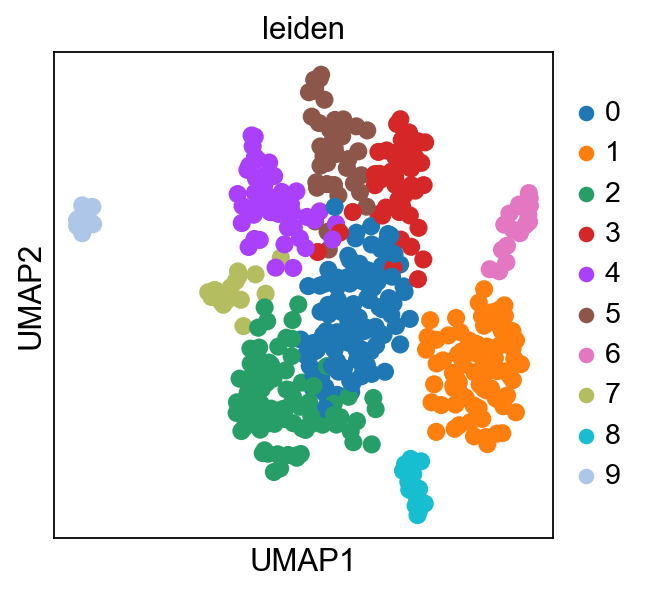

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


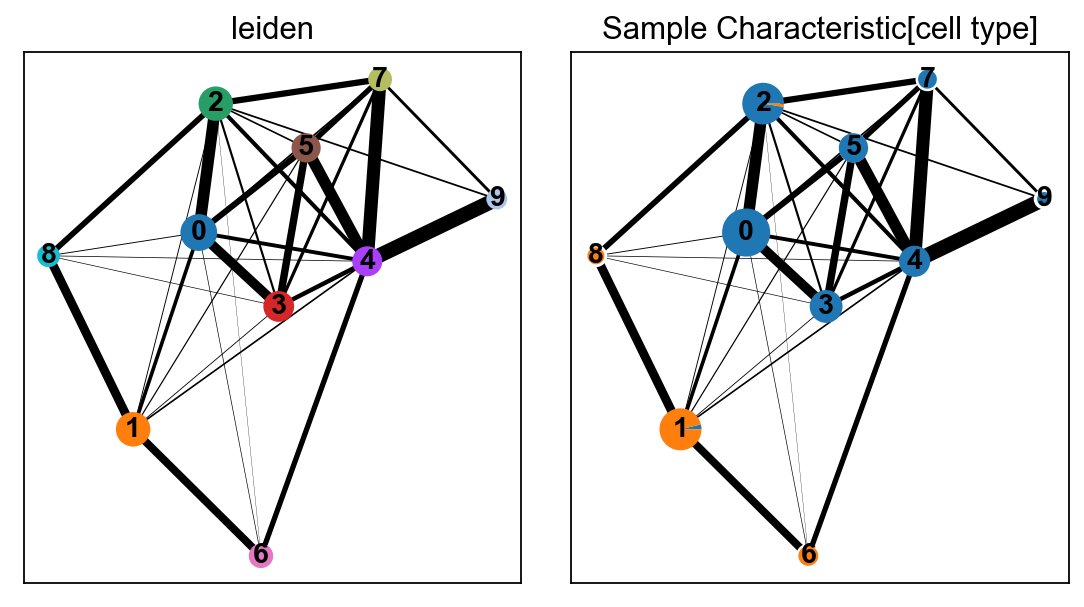

In [77]:
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.leiden(adata, resolution=1.0)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['leiden'])

sc.tl.paga(adata, groups='leiden')
sc.pl.paga(adata, color=['leiden', meta_class_column_name])

# 8. Trajectory inference

Trajectory inference is a computational technique used in single-cell transcriptomics to arrange cells based on their progression through the process. It orders single cells in pseudotime, placing them along a trajectory corresponding to a biological process such as cell differentiation by taking advantage of individual cell's asynchronous progression of those processes. Diffusion pseudotime (DPT)[12], which measures transitions between cells using diffusion-like random walks. 
Monocle[13] orders cells by learning an explicit principal graph from the single cell genomics data with advanced machine learning techniques (Reversed Graph Embedding), which robustly and accurately resolves complicated biological processes.

In [78]:
robjects.r('''
suppressMessages(library(dplyr))
suppressMessages(library(monocle))
suppressMessages(library(tibble))
suppressMessages(require(Matrix))
suppressMessages(require(VGAM))
suppressMessages(require(igraph))

# Make a CellDataSet object
# @expr_df: CPM expression data.frame (genes by samples) 
makeCellData <- function(expr_df) {
    genes <- rownames(expr_df)
    expr_mat = data.matrix(expr_df)
    num_cells_expressed <- (expr_mat > 0.1) + 0
    num_cells_expressed <- Matrix::rowSums(num_cells_expressed)
    fd <- data.frame(num_cells_expressed=num_cells_expressed, row.names = genes)
    fd <- new("AnnotatedDataFrame", data = fd)
    pd <- new("AnnotatedDataFrame", data = data.frame(row.names=colnames(expr_mat)))
    
    newCellDataSet(expr_mat,
        phenoData = pd,
        featureData = fd,
        lowerDetectionLimit = 0.1,
        expressionFamily = VGAM::tobit(0.1))
}

makeCellData3 <- function(expr_df) {
    genes <- rownames(expr_df)
    expr_mat = data.matrix(expr_df)
    num_cells_expressed <- (expr_mat > 0.1) + 0
    num_cells_expressed <- Matrix::rowSums(num_cells_expressed)
    fd <- data.frame(num_cells_expressed=num_cells_expressed, row.names = genes)
    fd <- new("AnnotatedDataFrame", data = fd)
    pd <- data.frame(row.names=colnames(expr_mat))
    # a hack to avoid error when running `partitionCells`
    pd['foo'] = 'bar'
    pd <- new("AnnotatedDataFrame", data = pd)
    
    newCellDataSet(expr_mat,
        phenoData = pd,
        featureData = fd,
        lowerDetectionLimit = 0.1)
}

getDEGsAsOrderingGenes <- function(cds){
    # get DEGs among clusters
    cds_expressed_genes <-  row.names(subset(fData(cds), num_cells_expressed >= 10))
    clustering_DEG_genes <- differentialGeneTest(cds[cds_expressed_genes,], 
        fullModelFormulaStr = '~Cluster',
        cores = 8)
    # order cells with top 1000 DEGs
    cds_ordering_genes <- row.names(clustering_DEG_genes)[order(clustering_DEG_genes$qval)][1:1000]
    cds_ordering_genes
}

getHighVarGenesAsOrderingGenes <- function(cds){
    # Use genes with highest variance as ordering genes
    RowVar <- function(x, ...) {
        # from https://stackoverflow.com/questions/25099825/row-wise-variance-of-a-matrix-in-r
        rowSums((x - rowMeans(x, ...))^2, ...)/(dim(x)[2] - 1)
    }
    # use genes with high variances for ordering cell
    gene_variances <- RowVar(exprs(cds))
    cds_ordering_genes <- names(gene_variances[order(gene_variances, decreasing = T)])[1:1000]
    cds_ordering_genes
}

# Run the entire Monocle-DDRTree pipeline to 
# 1) clustering
# 2) identify DEGs across clusters
# 3) ordering cells/psudotime estimation
runMonocleDDRTree <- function(cds, ordering = "de") {
    # tSNE and clustering cells
    cds <- reduceDimension(cds, 
        max_components = 2,
        norm_method = 'log',
        reduction_method = 'tSNE',
        perplexity = 5,
        verbose = T)

    n_cells <- as.numeric(dim(cds)[2])
    k <- 50 # default k for louvain clustering
    if (n_cells < 52){
        k <- n_cells - 2
    }
    cds <- clusterCells(cds, method="louvain", k=k, verbose = T)
    n_clusters <- length(unique(cds$Cluster))
    if (n_clusters > 1 && ordering == "de"){
        cds_ordering_genes <- tryCatch(
            {
                message("Attempting to compute DEGs across clusters for ordering cells...")
                getDEGsAsOrderingGenes(cds)
            },
            error=function(cond) {
                message("Error encountered while computing DEGs using monocle:")
                message(cond)
                message("Fall back to using most variable genes for ordering cells")
                getHighVarGenesAsOrderingGenes(cds)
            }
        )
    } else { # only 1 cluster
        message("Using most variable genes for ordering cells...")
        cds_ordering_genes <- getHighVarGenesAsOrderingGenes(cds)
    }
    cds <- setOrderingFilter(cds, ordering_genes = cds_ordering_genes)
    cds <- reduceDimension(cds, method = 'DDRTree', norm_method = 'log', 
        ncenter = NULL)
    cds <- orderCells(cds)
    return(cds)
}


runMonocleUMAPsimplePPT <- function(cds) {
    # 1. Noramlize and pre-process the data
    cds <- estimateSizeFactors(cds)
    cds <- preprocessCDS(cds, 
        num_dim = 50,
        norm_method = 'log',
        method = 'PCA'
        )
    # 2. Reduce the dimensionality of the data
    cds <- reduceDimension(cds, max_components = 3,
                           reduction_method = 'UMAP',
                           metric="cosine",
                           verbose = F)
    # 3. Partition the cells into supergroups
    cds <- partitionCells(cds)
    # 4. Learn the principal graph
    cds <- learnGraph(cds,
                      max_components = 3,
                      RGE_method = 'SimplePPT',
                      partition_component = T,
                      verbose = F)
    ## Not Implemented: Monocle 3 doesn't seem to support ordering by 
    # the expression of a list of genes. Will need know how to automatically
    # find the root cell instead.

    # # 5. order cells
    # cds <- orderCells(cds, 
    #     root_pr_nodes = get_correct_root_state(cds,
    #                                            cell_phenotype = 'cell_type2',
    #                                            "Multipotent progenitors"))
    return(cds)
}

# Convert cds object to edge_df and data_df for making plot
# @ref: https://github.com/cole-trapnell-lab/monocle-release/blob/ea83577c511564222bd08a35a9f944b07ccd1a42/R/plotting.R#L53
convertToDataFrames <- function(cds) {
    sample_name <- NA
    sample_state <- pData(cds)$State
    # data_dim_1 <- NA
    # data_dim_2 <- NA
    theta <- 0
    x <- 1
    y <- 2

    lib_info_with_pseudo <- pData(cds)

    reduced_dim_coords <- reducedDimK(cds)

    ica_space_df <- Matrix::t(reduced_dim_coords) %>%
      as.data.frame() %>%
      select_(prin_graph_dim_1 = x, prin_graph_dim_2 = y) %>%
      mutate(sample_name = rownames(.), sample_state = rownames(.))

    dp_mst <- minSpanningTree(cds)

    edge_df <- dp_mst %>%
      igraph::as_data_frame() %>%
      select_(source = "from", target = "to") %>%
      left_join(ica_space_df %>% select_(source="sample_name", source_prin_graph_dim_1="prin_graph_dim_1", source_prin_graph_dim_2="prin_graph_dim_2"), by = "source") %>%
      left_join(ica_space_df %>% select_(target="sample_name", target_prin_graph_dim_1="prin_graph_dim_1", target_prin_graph_dim_2="prin_graph_dim_2"), by = "target")

    data_df <- t(monocle::reducedDimS(cds)) %>%
      as.data.frame() %>%
      select_(x = x, y = y) %>%
      rownames_to_column("sample_name") %>%
      mutate(sample_state) %>%
      left_join(lib_info_with_pseudo %>% rownames_to_column("sample_name"), by = "sample_name")

    return_rotation_mat <- function(theta) {
      theta <- theta / 180 * pi
      matrix(c(cos(theta), sin(theta), -sin(theta), cos(theta)), nrow = 2)
    }
    rot_mat <- return_rotation_mat(theta)

    cn1 <- c("x", "y")
    cn2 <- c("source_prin_graph_dim_1", "source_prin_graph_dim_2")
    cn3 <- c("target_prin_graph_dim_1", "target_prin_graph_dim_2")
    data_df[, cn1] <- as.matrix(data_df[, cn1]) %*% t(rot_mat)
    edge_df[, cn2] <- as.matrix(edge_df[, cn2]) %*% t(rot_mat)
    edge_df[, cn3] <- as.matrix(edge_df[, cn3]) %*% t(rot_mat)
    # Drop the redundant sample_state column
    data_df[,"sample_state"] = NULL
    return(list(edge_df=edge_df, data_df=data_df))
}


convertToDataFrames3 <- function(cds) {
    sample_name <- NA
    sample_state <- pData(cds)$louvain_component

    x <- 1
    y <- 2
    z <- 3

    lib_info_with_pseudo <- pData(cds)

    reduced_dim_coords <- reducedDimK(cds)

    ica_space_df <- Matrix::t(reduced_dim_coords) %>%
      as.data.frame() %>%
      select_(prin_graph_dim_1 = x, prin_graph_dim_2 = y, prin_graph_dim_3 = z) %>%
      mutate(sample_name = rownames(.), sample_state = rownames(.))

    dp_mst <- minSpanningTree(cds)

    edge_df <- dp_mst %>%
      igraph::as_data_frame() %>%
      select_(source = "from", target = "to") %>%
      left_join(ica_space_df %>% select_(source="sample_name", source_prin_graph_dim_1="prin_graph_dim_1", 
          source_prin_graph_dim_2="prin_graph_dim_2", 
          source_prin_graph_dim_3="prin_graph_dim_3"), by = "source") %>%
      left_join(ica_space_df %>% select_(target="sample_name", target_prin_graph_dim_1="prin_graph_dim_1", 
          target_prin_graph_dim_2="prin_graph_dim_2", 
          target_prin_graph_dim_3="prin_graph_dim_3"), by = "target")

    data_df <- t(monocle::reducedDimS(cds)) %>%
      as.data.frame() %>%
      select_(x = x, y = y, z = z) %>%
      rownames_to_column("sample_name") %>%
      mutate(sample_state) %>%
      left_join(lib_info_with_pseudo %>% rownames_to_column("sample_name"), by = "sample_name")

    # Drop the redundant sample_state column
    data_df[,"sample_state"] = NULL
    return(list(edge_df=edge_df, data_df=data_df))
}

#  Run the entire Monocle pipeline
runMonoclePipeline <- function(expr_df, ordering = "de") {
    cds <- makeCellData(expr_df)
    cds <- runMonocleDDRTree(cds, ordering = ordering)
    convertToDataFrames(cds)    
}

runMonocle3Pipeline <- function(expr_df){
    cds <- makeCellData3(expr_df)
    cds <- runMonocleUMAPsimplePPT(cds)
    convertToDataFrames3(cds)
}
''')

R object with classes: ('function',) mapped to:

In [79]:
runMonoclePipeline = robjects.globalenv['runMonoclePipeline']
def run_monocle(dataset, color_by='Pseudotime', ordering='de', plot_type='interactive'):
    # Compute CPM
    dataset['CPM'] = CPM(dataset['rawdata'])
    data = dataset['CPM']
    # Run Monocle
    results_monocle = runMonoclePipeline(pandas2ri.conversion.py2rpy(data), ordering=ordering)
    monocle_results = {}
    for key in list(results_monocle.names):
        df = pandas2ri.conversion.rpy2py(results_monocle[int(np.where(results_monocle.names==key)[0][0])])
        monocle_results[key] = df

    monocle_results['data_df'].set_index('sample_name', inplace=True)
    monocle_results['sample_metadata'] = dataset['sample_metadata'].merge(
        monocle_results['data_df'],
        left_index=True,
        right_index=True
        )
    # Return
    monocle_results.update(
        {'color_by': color_by, 'plot_type': plot_type}
        )
    return monocle_results

def plot_monocle(monocle_results, debug=False):
    # Get results
    sample_metadata = monocle_results['sample_metadata']
    color_by = monocle_results.get('color_by')

    color_type = 'continuous'
    if color_by == 'State':
        color_type = 'categorical'
        
    color_column = monocle_results['sample_metadata'][color_by] if color_by else None
    sample_titles = ['<b>{}</b><br>'.format(index)+'<br>'.join('<i>{key}</i>: {value}'.format(**locals()) for key, value in rowData.items()) for index, rowData in sample_metadata.iterrows()]

    # Make a trace for the trajectory
    edge_trace = go.Scatter(
        x=[],
        y=[],
        line=dict(width=1,color='#888'),
        hoverinfo='none',
        name='trajectory',
        mode='lines')

    for _, row in monocle_results['edge_df'].iterrows():
        x0, y0 = row['source_prin_graph_dim_1'], row['source_prin_graph_dim_2']
        x1, y1 = row['target_prin_graph_dim_1'], row['target_prin_graph_dim_2']
        edge_trace['x'] += (x0, x1, None)
        edge_trace['y'] += (y0, y1, None)
    
    if color_by and color_type == 'continuous':
        marker = dict(size=5, color=color_column, colorscale='Viridis', showscale=True)
        trace = go.Scatter(x=monocle_results['data_df']['x'],
            y=monocle_results['data_df']['y'],
            mode='markers',
            hoverinfo='text',
            text=sample_titles,
            marker=marker,
            name='Cells'
            )
        data = [trace, edge_trace]

    elif color_by and color_type == 'categorical' and len(color_column.unique()) <= len(s.colors):

        # Get unique categories
        unique_categories = color_column.unique()

        # Define empty list
        data = []
            
        # Loop through the unique categories
        for i, category in enumerate(unique_categories):

            # Get the color corresponding to the category
            category_color = s.colors[i]

            # Get the indices of the samples corresponding to the category
            category_indices = [i for i, sample_category in enumerate(color_column) if sample_category == category]
            
            # Create new trace
            trace = go.Scatter(x=monocle_results['data_df']['x'].values[category_indices],
                                 y=monocle_results['data_df']['y'].values[category_indices],
                                 mode='markers',
                                 hoverinfo='text',
                                 text=[sample_titles[x] for x in category_indices],
                                 name = category,
                                 marker=dict(size=5, color=category_color))
            
            # Append trace to data list
            data.append(trace)
        data.append(edge_trace)
    else:
        marker = dict(size=5)
        trace = go.Scatter(x=monocle_results['data_df']['x'],
                    y=monocle_results['data_df']['y'],
                    mode='markers',
                    hoverinfo='text',
                    text=sample_titles,
                    marker=marker)
        data = [trace, edge_trace]
    
    colored = '' if str(color_by) == 'None' else 'Colored by {}'.format(color_by)
    layout = go.Layout(title='<b>Monocle Analysis | Cell Trajectory Plot</b><br><i>{}</i>'.format(colored), hovermode='closest', margin=go.Margin(l=0,r=0,b=0,t=50), width=900,
        scene=dict(xaxis=dict(title='Component 1'), yaxis=dict(title='Component 2')))
    fig = go.Figure(data=data, layout=layout)
    if monocle_results['plot_type']=='interactive':
        plotly.offline.iplot(fig)
    else:
        py.image.ishow(fig)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:00)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.97959644 0.95243645 0.9280383  0.90883267 0.90711176
     0.8969049  0.8837844  0.8810849  0.8258677  0.7791776  0.74652725
     0.7292112  0.7240871  0.7226116 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


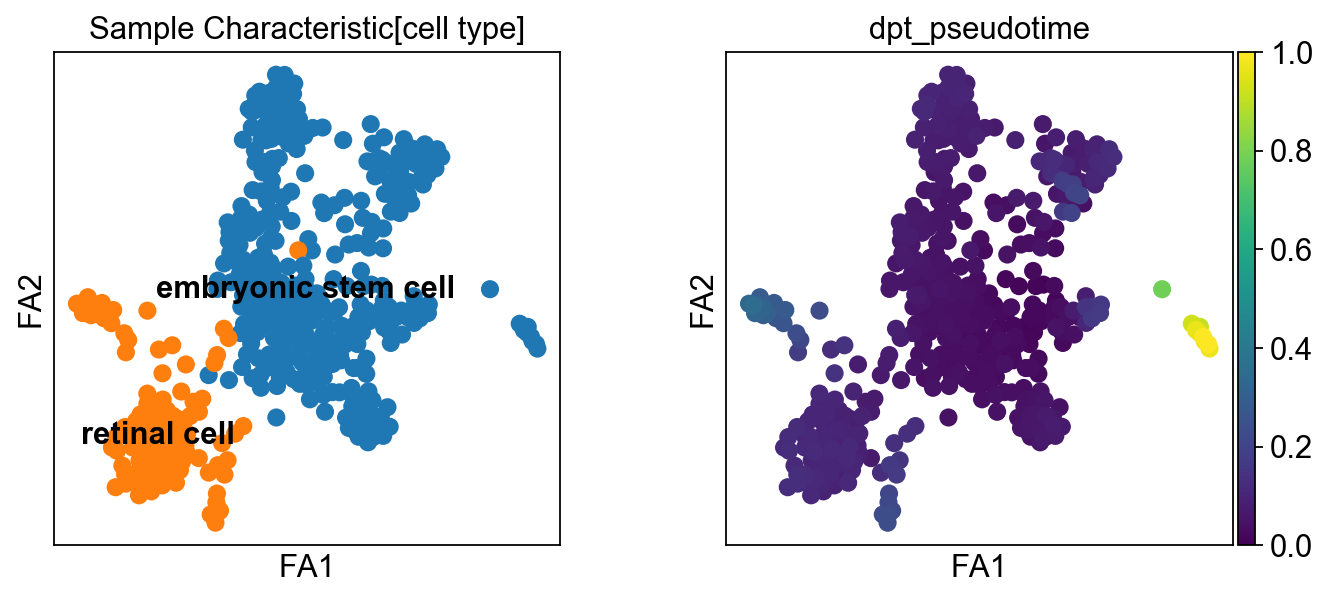

In [80]:
if trajectory_method == "monocle":
    # Run analysis
    results['monocle'] = run_monocle(dataset=dataset, plot_type=plot_type, color_by='Pseudotime')

    # Display results
    plot_monocle(results['monocle'])
elif trajectory_method == "dpt":
    adata.uns['iroot'] = 0
    sc.tl.draw_graph(adata)
    sc.tl.dpt(adata)
    sc.pl.draw_graph(adata, color=[meta_class_column_name, 'dpt_pseudotime'], legend_loc='on data')

# 9. Enrichment analysis

Enrichment analysis is a statistical procedure used to identify biological terms which are over-represented in a given gene set. These include signaling pathways, molecular functions, diseases, and a wide variety of other biological terms obtained by integrating prior knowledge of gene function from multiple resources. Enrichr[14] is a web-based application which allows to perform enrichment analysis using a large collection of gene-set libraries and various interactive approaches to display enrichment results.

In [81]:
def _rank_genes_wrapper(d, plot=False):
    categories = adata.uns['rank_genes_groups']['names'].dtype.names
    topk_ranked_genes = dict()
    for i in range(len(categories)):
        topk_ranked_genes_by_category = []
        for j in range(len(adata.uns['rank_genes_groups']['names'])):
            
            gene_name = adata.uns['rank_genes_groups']['names'][j][i]
            logfc = d["logfoldchanges"][j][i]
            pvals = d["pvals"][j][i]
            pvals_adj = d["pvals_adj"][j][i]
            topk_ranked_genes_by_category.append([gene_name, logfc, pvals, pvals_adj])
            
        tmpdf = pd.DataFrame(topk_ranked_genes_by_category)
        tmpdf.columns = ["Gene symbol", "logFC", "pvals", "pvals_adj"]
        tmpdf = tmpdf.set_index("Gene symbol")
        topk_ranked_genes[categories[i]] = tmpdf
        if plot == True:
            display(Markdown("Gene signature table for {}".format(categories[i])))
            display(tmpdf)
    return topk_ranked_genes


In [82]:
def get_genesets(signature_dataframe, signature_col, top_n=True, nr_genes=500):
    genesets = {}
    sorted_genes = signature_dataframe.sort_values(signature_col).index
    genesets['upregulated'] = sorted_genes[-nr_genes:]
    genesets['downregulated'] = sorted_genes[:nr_genes]
    return genesets

def submit_enrichr_geneset(geneset, label):
    ENRICHR_URL = 'https://amp.pharm.mssm.edu/Enrichr/addList'
    genes_str = '\n'.join(geneset)
    payload = {
        'list': (None, genes_str),
        'description': (None, label)
    }
    response = requests.post(ENRICHR_URL, files=payload)
    if not response.ok:
        raise Exception('Error analyzing gene list')
    time.sleep(0.5)
    data = json.loads(response.text)
    return data

def run_enrichr(signatures, geneset_size=100, libraries=['GO_Biological_Process_2017b', 'ENCODE_TF_ChIP-seq_2015', 'KEGG_2016', 'ARCHS4_TFs_Coexp', 'MGI_Mammalian_Phenotype_2017'], signature_label=''):
    # Get genesets
    genesets = {cluster_name: signature.index[:geneset_size] for cluster_name, signature in signatures.items()}

    # Submit to Enrichr
    enrichr_ids = {geneset_label: submit_enrichr_geneset(geneset=geneset, label=geneset_label) for geneset_label, geneset in genesets.items()}
    return enrichr_ids

#############################################
########## 2. Plot
#############################################

def plot_enrichr(enrichr_ids):
    markdown_text = '##### Signature genes from each clusters:\n'
    for cluster_name, enrichr_res in enrichr_ids.items():
        markdown_text += ' + **%s:** https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=%s \n' % (cluster_name, enrichr_res['shortId'])

    display(Markdown(markdown_text))


In [83]:
def get_signature(enrichment_groupby, dataset, method='wilcoxon', nr_genes=200):
    if enrichment_groupby == "cluster":
        sc.tl.rank_genes_groups(dataset, 'leiden', method=method, n_genes=nr_genes)
    elif enrichment_groupby == "cell_type":
        sc.tl.rank_genes_groups(dataset, meta_class_column_name, method=method, n_genes=nr_genes)
        
    return dataset

In [84]:
# Run analysis
adata = get_signature(enrichment_groupby=enrichment_groupby, dataset=adata, nr_genes=nr_genes)
signatures = _rank_genes_wrapper(adata.uns['rank_genes_groups'])

results['enrichr'] = run_enrichr(signatures=signatures, geneset_size=200)

# Display results
plot_enrichr(results['enrichr'])

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


##### Signature genes from each clusters:
 + **0:** https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=826ad66bcdec0dcd4adcdbcbd1b59bec 
 + **1:** https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=523919fe99be2c35e4c3ad75359218f6 
 + **2:** https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=f12d2a03c5033519fdd9bee3eb80ed4e 
 + **3:** https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=f6fe6a0f0326f4d70f2c07427926bf6c 
 + **4:** https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=d0ab87da2bb2c911ef40bbe8ae2dd152 
 + **5:** https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=91f55874e68a19a49d446d481020f0fc 
 + **6:** https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=22e043894da4afd5b521fda852df3d06 
 + **7:** https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=20ee528d2177eb81772fec5e606399bd 
 + **8:** https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=c44faccef9ee3bd6bd3e9418cdcc0896 
 + **9:** https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=efad76dbca1a2e739e5ff3c21fb69917 


# 10. Gene Ontology Enrichment Analysis

Gene Ontology (GO)[15] is a major bioinformatics initiative aimed at unifying the representation of gene attributes across all species. It contains a large collection of experimentally validated and predicted associations between genes and biological terms. This information can be leveraged by Enrichr to identify the biological processes, molecular functions and cellular components which are over-represented in the up-regulated genes from each cluster.

In [85]:
def get_enrichr_results(user_list_id, gene_set_libraries, overlappingGenes=True, geneset=None):
    ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/enrich'
    query_string = '?userListId=%s&backgroundType=%s'
    results = []
    for gene_set_library, label in gene_set_libraries.items():
        response = requests.get(
                    ENRICHR_URL +
                       query_string % (user_list_id, gene_set_library)
                )
        if not response.ok:
            raise Exception('Error fetching enrichment results')

        data = json.loads(response.text)
        resultDataframe = pd.DataFrame(data[gene_set_library], columns=[
                                       'rank', 'term_name', 'pvalue', 'zscore', 'combined_score', 'overlapping_genes', 'FDR', 'old_pvalue', 'old_FDR'])
        selectedColumns = ['term_name', 'zscore', 'combined_score', 'pvalue', 'FDR'] if not overlappingGenes else [
            'term_name', 'zscore', 'combined_score', 'FDR', 'pvalue', 'overlapping_genes']
        resultDataframe = resultDataframe.loc[:, selectedColumns]
        resultDataframe['gene_set_library'] = label
        resultDataframe['log10P'] = -np.log10(resultDataframe['pvalue'])
        results.append(resultDataframe)
    concatenatedDataframe = pd.concat(results)
    if geneset:
        concatenatedDataframe['geneset'] = geneset
    return concatenatedDataframe


def run_go(enrichr_results, plot_type='interactive', nr_genesets=10):
    
    # Libraries
    libraries = {
        'GO_Biological_Process_2018': 'Gene Ontology Biological Process',
        'GO_Molecular_Function_2018': 'Gene Ontology Molecular Function',
        'GO_Cellular_Component_2018': 'Gene Ontology Cellular Component'
    }

    # Get Enrichment Results
    enrichment_results = {geneset_label: get_enrichr_results(enrichr_ids['userListId'], gene_set_libraries=libraries, geneset=geneset_label) 
        for geneset_label, enrichr_ids in enrichr_results.items()}

    # Return
    return {'enrichment_results': enrichment_results, 'plot_type': plot_type, "nr_genesets":nr_genesets}

def plot_go(enrichr_results):
    # Create dataframe
    enrichment_dataframe = pd.concat(enrichr_results['enrichment_results'].values())

    # Plot barcharts
    libraries = enrichment_dataframe['gene_set_library'].unique()
    if len(libraries):

        # Barcharts
        for gene_set_library in libraries:
            plot_library_barchart(enrichr_results, gene_set_library, enrichr_results["nr_genesets"], 300)


def plot_library_barchart(enrichr_results, gene_set_library, nr_genesets, height):
    # Calculate the number of subplots
    n_panels = len(enrichr_results['enrichment_results']) # 2 <= n_panels <= 10
    n_rows = math.ceil(n_panels / 3)
    n_cols = min(n_panels, 3)
    color_dict = {"Gene Ontology Biological Process": "#F59EA5", 
              "Gene Ontology Molecular Function": "#B0CFFF", 
              "Gene Ontology Cellular Component": "#FFEA9A"}
    
    colors = [color_dict[gene_set_library]]*len(enrichr_results['enrichment_results'].keys())
    
    fig = tools.make_subplots(rows=n_rows, cols=n_cols, print_grid=False, 
        subplot_titles=list(enrichr_results['enrichment_results'].keys()))
    for i, geneset in enumerate(enrichr_results['enrichment_results'].keys()):
        # Get dataframe
        enrichment_dataframe = enrichr_results['enrichment_results'][geneset]
        plot_dataframe = enrichment_dataframe[enrichment_dataframe['gene_set_library'] == gene_set_library].sort_values(
            'combined_score', ascending=False).iloc[:nr_genesets].iloc[::-1]

        # Format
        n = 7
        plot_dataframe['nr_genes'] = [len(genes) for genes in plot_dataframe['overlapping_genes']]
        plot_dataframe['overlapping_genes'] = ['<br>'.join([', '.join(genes[i:i+n]) for i in range(0, len(genes), n)]) for genes in plot_dataframe['overlapping_genes']]
        
        # Get Bar
        bar = go.Bar(
            x=plot_dataframe['combined_score'],
            y=plot_dataframe['term_name'],
            orientation='h',
            name=geneset.title(),
            showlegend=False,
            hovertext=['<b>{term_name}</b><br><b>P-value</b>: <i>{pvalue:.2}</i><br><b>FDR</b>: <i>{FDR:.2}</i><br><b>Z-score</b>: <i>{zscore:.3}</i><br><b>Combined score</b>: <i>{combined_score:.3}</i><br><b>{nr_genes} Genes</b>: <i>{overlapping_genes}</i><br>'.format(**rowData) 
                for index, rowData in plot_dataframe.iterrows()],
            hoverinfo='text',
            marker={'color': colors[i]}
        )
        row = math.ceil( (i+1) / 3 )
        col = (i+1) % 3
        if col == 0:
            col = 3
        fig.append_trace(bar, row, col)

        # Get text
        text = go.Scatter(
            x=[max(bar['x'])/50 for x in range(len(bar['y']))],
            y=bar['y'],
            mode='text',
            hoverinfo='none',
            showlegend=False,
            text=['*<b>{}</b>'.format(rowData['term_name']) if rowData['FDR'] < 0.1 else '{}'.format(
                rowData['term_name']) for index, rowData in plot_dataframe.iterrows()],
            textposition="middle right",
            textfont={'color': 'black'}
        )
        fig.append_trace(text, row, col)

    domains = [(0, 0.49), (0.51, 1)]
    if n_cols == 3:
        domains = [(0, 0.31), (0.33, 0.64), (0.66, 1)] * 4
    
    # Get title
    title = gene_set_library

    fig['layout'].update(height=height*n_rows, title='<b>{}</b>'.format(title),
                         hovermode='closest')    
    for i in range(n_panels):
        fig['layout']['xaxis%d' % (i+1)].update(domain=domains[i], title='', automargin=True)
        fig['layout']['yaxis%d' % (i+1)].update(showticklabels=False, automargin=True)

    fig['layout']['margin'].update(l=0, t=65, r=0, b=30)
    
    if enrichr_results['plot_type']=='interactive':
        plotly.offline.iplot(fig)
    else:
        py.image.ishow(fig)
    

In [86]:
# Run analysis
results['go_enrichment'] = run_go(enrichr_results=results['enrichr'], plot_type=plot_type, nr_genesets=nr_genesets)

    # Display results
plot_go(results['go_enrichment'])

# 11. SingleR cell type prediction

SingleR[16] is an unbiased cell type recognition algorithm for scRNA-seq. It leverages reference transcriptomic datasets of pure cell types to infer the cell of origin of each of the single cells independently.

In [87]:
robjects.r('''
suppressMessages(library(SingleR))
suppressMessages(library(scater))
suppressMessages(library(scRNAseq))

#' @param expr_df needs to be a data.frame of counts
#' @param species The species of the sample ('Human' or 'Mouse').
#' @param ref a name of the reference object: 
#'     Mouse: immgen, mouse.rnaseq, archs4_mouse_tissues
#'     Human: hpca and blueprint_encode, gtex, archs4_human_cell_lines, archs4_human_tissues 

runSingler <- function(expr_df, labels, species='Human', 
    ref='hpca') {
    if (species == 'Human'){
        hpca.se <- HumanPrimaryCellAtlasData()
    } else { 
        hpca.se <- MouseRNAseqData()
    }
    hESCs <- calculateTPM(expr_df)
    
    # Grab the common genes between the sets.
    common <- intersect(rownames(hESCs), rownames(hpca.se))
    hpca.se <- hpca.se[common,]
    hESCs <- hESCs[common,]
    # Test and reference sets should always be log normalized. The included reference sets are already normalized. 
    
    pred.hpca <- SingleR(test = hESCs, ref = hpca.se, 
    labels = hpca.se$label.fine)
    
    results = data.frame(scores=pred.hpca$scores, labels=pred.hpca$labels)
    }
''')

R object with classes: ('function',) mapped to:

In [88]:
runSingler = robjects.globalenv['runSingler']
def run_singler(dataset, species='Human', ref=None, plot_type='interactive'):
   
    expr_df = dataset.raw.to_adata().to_df().T
    # available references in SingleR:
    ref_dict = {
        'Human': ['hpca', 'blueprint_encode'],
        'Mouse': ['mouse.rnaseq', 'immgen']
        }
    if ref is None:
        ref = ref_dict[species][0]
    if ref == 'mouse_rnaseq':
        ref = 'mouse.rnaseq'
    # Remove duplicated genes (case insensitive)
    _, unique_idx = np.unique(expr_df.index.map(lambda x: x.lower()), return_index=True)
    expr_df = expr_df.iloc[unique_idx]
    # Run SingleR
    singler_results = runSingler(pandas2ri.conversion.py2rpy(expr_df), species=species, ref=ref)

    parsed_results = {}
    cols_to_parse = ['scores', 'labels']
    sample_metadata = pd.DataFrame(dataset.obs.loc[:, meta_class_column_name])
    
    if 'cluster_labels' in sample_metadata.columns:
        # Bind the clustering results to the singler result if available
        cols_to_parse = ['scores', 'labels']
        parsed_results['clusters'] = dataset['sample_metadata']['cluster_labels']

    for key in cols_to_parse:
        rdf = pandas2ri.conversion.rpy2py(singler_results)
        df = rdf.loc[:,rdf.columns.str.startswith(key)]
        df.columns = [x.replace(key+".","") for x in df.columns]
        parsed_results[key] = df

    parsed_results['scores'].index = expr_df.columns
    parsed_results['clusters'] = dataset.obs.leiden
    return parsed_results


def plot_singler(results, top_n=40, debug=False):
    scores_df = results['scores'] # cells by labels
    def r(): return random.randint(0, 255)
    colors = ['#%02X%02X%02X' % (r(), r(), r())
                      for i in range(len(np.unique(results['clusters'])))]
    
    z_scores = stats.zscore(scores_df.values)
    # Get a mask for top N labels to plot
    if z_scores.shape[1] > top_n:
        label_z_maxs = z_scores.max(axis=0)
        top_n_label_mask = label_z_maxs.argsort()[:top_n]
        
    # Stretch scores to [0, 1]
    scores = scores_df.values.T
    scores_stretched = (scores - scores.min(axis=0)) / (scores.max(axis=0) - scores.min(axis=0))
    scores_stretched = scores_stretched ** 3

    scores_df = pd.DataFrame(scores_stretched.T, index=scores_df.index, columns=scores_df.columns) 
    if z_scores.shape[1] > top_n:
        # Keep the top N labels
        scores_df = scores_df.iloc[:, top_n_label_mask]
    # Make samples colored by clustering labels
    cluster_colors = dict(zip(np.unique(results['clusters']), colors ))
    col_colors = [cluster_colors[c] for c in results['clusters']]
    col_colors = pd.Series(col_colors, index=results['scores'].index, name='cluster')
    cg = sns.clustermap(scores_df.transpose(), cmap='Reds', 
        vmin=0, vmax=1,
        col_colors=col_colors,
        cbar_kws={'label': 'probability'},
        xticklabels=False,
        yticklabels=True,
        figsize=(8, 12))
    return 

In [89]:
if singleR_analysis == True:
    # Run analysis
    results['singler'] = run_singler(dataset=adata, plot_type=plot_type, species=species)

    # Display results
    plot_singler(results['singler'])

# 12. Library size analysis

In order to quantify gene expression in an RNA-seq dataset, reads generated from the sequencing step are mapped to a reference genome and subsequently aggregated into numeric gene counts. Due to experimental variations and random technical noise, samples in an RNA-seq datasets often have variable amounts of the total RNA. Library size analysis calculates and displays the total number of reads mapped for each sample in the RNA-seq dataset, facilitating the identification of outlying samples and the assessment of the overall quality of the data.

In [90]:
adata.obs['n_counts'] = adata.raw.to_adata().X.sum(axis=1)
library_sum_df = pd.DataFrame(adata.obs['n_counts'])
fig = px.bar(library_sum_df.sort_values(by='n_counts'), x=library_sum_df.index, y='n_counts')
if plot_type=='interactive':
    plotly.offline.iplot(fig)
else:
    py.image.ishow(fig)

# References 